In [1]:
import sys
sys.path.insert(0, './utils')

import numpy as np
import random
import itertools
import matplotlib.pyplot as plt

from game import *
from tools import *
from tqdm import trange, tqdm
from scipy import interpolate

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Let's play one against the other 

In [2]:
cards = ["Ace", "King", "Queen", "Jack", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
signs = ["Club", "Diamond", "Heart", "Spade"]
initialW = 100
n = 7
m = 11
it = int(5*1e3)
lr = .5
exp = 1e-2
step = 1e-5
alpha = 3.
decay = 1.
maxBet = 10
retreat = 1
parameters = np.ones((2*(m-n)+1, maxBet, 2))*1e-5

In [3]:
class Game(): 
    
    def __init__(self, firstPlayer, secondPlayer):
        self.cards = 4*list(range(n, m+1))
        self.firstPlayer = firstPlayer
        self.secondPlayer = secondPlayer
        self.turn = random.randint(0, 1)
        
    def deal(self):
        random.shuffle(self.cards)
        self.turn = 1 - self.turn
        self.firstPlayer.hand = [self.cards[0], self.cards[2]]
        self.firstPlayer.sum = sum(self.firstPlayer.hand)
        self.secondPlayer.hand = [self.cards[1], self.cards[3]]
        self.secondPlayer.sum = sum(self.secondPlayer.hand)
        
    def reset(self):
        self.secondPlayer.reset()
        self.firstPlayer.reset()
        self.turn = random.randint(0, 1)
        
    def learn(self, rounds = 10):

        score = 0
        for _ in range(rounds):
            self.reset()
            while self.firstPlayer.worth * self.secondPlayer.worth > 0:
                self.deal()
                simplePlay(self.firstPlayer, self.secondPlayer, self.turn)
            score += (self.firstPlayer.worth > 0)
            
        return score
    
    def human(self, results = True):

        self.reset()
        while self.firstPlayer.worth * self.secondPlayer.worth > 0:
            self.deal()
            simplePlay(self.firstPlayer, self.secondPlayer, self.turn)
            
            if results:
                print("-------------------------")
                print("The {0} hand and last action were: {1}-{2}".format(self.secondPlayer.name, self.secondPlayer.hand, self.secondPlayer.action))
                print("-------------------------")
                print("The {0} hand and last action were: {1}-{2}".format(self.firstPlayer.name, self.firstPlayer.hand, self.firstPlayer.action))
                print("-------------------------")
                print("Current Net Worth of {0}: {1} - Current Net Worth of {2}: {3}".format(self.firstPlayer.name, self.firstPlayer.worth, self.secondPlayer.name, self.secondPlayer.worth))
                print("=========================")
            
        if self.secondPlayer.worth > 0:
            print("\n And the final winner is {0}! :)".format(self.secondPlayer.name))
        else:
            print("\n And the final winner is {0}! :>".format(self.firstPlayer.name))

# TD Player

In [4]:
class Player:
    
    def __init__(self, name = "Player", lr = lr, exp = exp):
        self.trainable = True
        self.worth = initialW
        self.statDict = {}
        self.lr = lr
        self.exp = exp
        self.name = name
        self.maxBet = maxBet
        
    def reset(self):
        self.worth = initialW
        
    def chooseAction(self, actions, advAction):
        state = str(self.sum) + "-" + str(advAction)
        if random.random() < self.exp or self.statDict.get(state) is None:
            return random.choice(actions)
        action = int(max(self.statDict.get(state), key = lambda x: self.statDict.get(state)[x]))
        return action
        
    def update(self, adverser, boolean = True):
        if self.trainable:
            if adverser.action > 0:
                if boolean:
                    state = str(self.sum) + "-" + str(None)
                else:
                    state = str(self.sum) + "-" + str(adverser.action)
                    
                if self.statDict.get(state) is None:
                    self.statDict[state] = {}
                if self.statDict.get(state).get(str(self.action)) is None:
                    self.statDict[state][str(self.action)] = 0

                if self.action == adverser.action:
                    if self.sum > adverser.sum:
                        self.statDict[state][str(self.action)] += self.lr*( 1 - self.statDict[state][str(self.action)])
                    elif self.sum < adverser.sum:
                        self.worth -= self.action
                        self.statDict[state][str(self.action)] += self.lr*(-1 - self.statDict[state][str(self.action)])

                elif self.action == 0:
                    self.worth -= retreat
                    self.statDict[state][str(self.action)] += self.lr*(- retreat - self.statDict[state][str(self.action)])

        else:
            if self.action == adverser.action and self.sum < adverser.sum:
                self.worth -= self.action
            elif self.action == 0:
                self.worth -= retreat
        

# Human Player

In [5]:
class HumanPlayer(Player):
    
    def __init__(self, name = "HumanPlayer"):
        Player.__init__(self)
        self.name = name
        
    def chooseAction(self, actions, advAction):
        print("State: ", self.hand)
        
        if advAction is None: 
            pass
        else:
            print("Adverser played: ", advAction)
            
        action = int(input("Input your action: ")) 
        
        while action not in actions:
            print("Try a number in ", actions)
            action = int(input("Input your action: "))  
            
        return action
    
    def update(self, adverser, boolean = True):
        if self.action == adverser.action and self.sum < adverser.sum:
            self.worth -= self.action
        elif self.action == 0:
            self.worth -= retreat

# Greedy Player

In [6]:
class GreedyPlayer(Player):
    
    def __init__(self, name = "GreedyPlayer"):
        Player.__init__(self)
        self.name = name
        
    def chooseAction(self, actions, advAction):
        if advAction is None:
            return random.choice(actions)
        if self.sum > m + n:
            return advAction
        return 0
    
    def update(self, adverser, boolean = True):
        if self.action == adverser.action and self.sum < adverser.sum:
            self.worth -= self.action
        elif self.action == 0:
            self.worth -= retreat

# Determinstic Player

In [7]:
class DeterminsticPlayer(Player):
    
    def __init__(self, name = "DeterminsticPlayer"):
        Player.__init__(self)
        self.name = name
        
    def chooseAction(self, actions, advAction):
        if advAction is None:
            k= 2*(m-n)+1
            for i in range(k):
                if self.sum <= i + 2*n:
                    return int(maxBet*i/k)
        return 0
    
    def update(self, adverser, boolean = True):
        if self.action == adverser.action and self.sum < adverser.sum:
            self.worth -= self.action
        elif self.action == 0:
            self.worth -= retreat

# Who's better

## Train

In [8]:
firstPlayer = Player()
secondPlayer = Player()
game = Game(firstPlayer, secondPlayer)
game.learn(it)

2404

In [9]:
determinsticPlayer = DeterminsticPlayer()
game = Game(determinsticPlayer, secondPlayer)
game.learn(it)

672

## Eval

In [10]:
learning = []
rounds = 50
epochs = 100

firstPlayer = Player()
for _ in trange(epochs):
    learning.append(Game(firstPlayer, DeterminsticPlayer()).learn(rounds))

100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 27.81it/s]


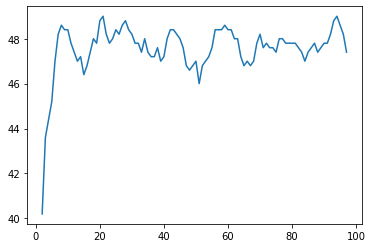

In [11]:
x, y = smooth(learning, 5)
plt.plot(x, y)

In [12]:
learning = []
rounds = 10
epochs = 100

for _ in trange(epochs):
    learning.append(Game(Player(), DeterminsticPlayer()).learn(rounds))

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.35it/s]


In [13]:
learning.count(0)

9

## Info

In [14]:
firstPlayer.statDict.get("21-None")

# Who's better Zayed or the computer ?

In [15]:
# game = Game(firstPlayer, HumanPlayer())
# game.human(results = True)